## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2, os
import math
from sklearn.linear_model import LinearRegression
from collections import deque
%matplotlib inline

### Check data

In [2]:
test_path = './test_images/'
imgs = [cv2.imread(os.path.join(test_path, x)) for x in os.listdir(test_path) ]

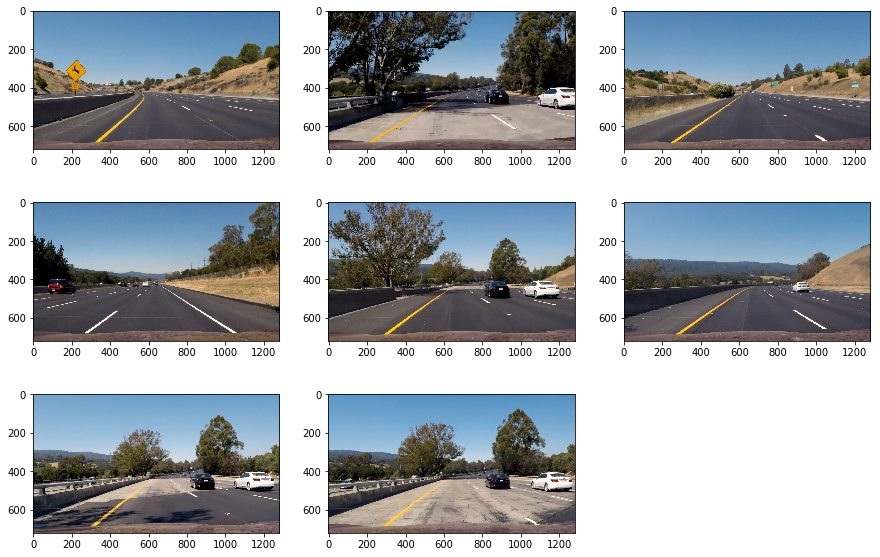

In [3]:
fig = plt.figure(figsize=(15,10))
for i, img in enumerate(imgs):
    fig.add_subplot(3,3,i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [74]:
class HoughLines:
    def __init__(self, cmaps=[(cv2.COLOR_BGR2GRAY, None)], prepocess=False, keep=5, serial_mode=False,
                 init_cmap='RGB', clip_limit=2.0, tile_grid=8):
        self.cmaps = cmaps
        self.prepocess = prepocess
        self.keep = keep
        self.serial_mode = serial_mode
        self.buf = deque([], self.keep)
        self.pos_coef_buf = deque([], self.keep)
        self.neg_coef_buf = deque([], self.keep)
        self.cntr = 0
        self.log = []
        self.init_cmap = init_cmap
        self.clip_limit = clip_limit
        self.tile_grid = tile_grid
        
    def preprocess_img(self, img, preprocess):
        if preprocess:
            code = eval('cv2.COLOR_'+self.init_cmap+'2LAB')
            inv_code = eval('cv2.COLOR_LAB2'+self.init_cmap)
            l, a, b = cv2.split(cv2.cvtColor(img, code))
            clahe = cv2.createCLAHE(clipLimit=self.clip_limit,
                                    tileGridSize=(self.tile_grid,self.tile_grid))
            l_c = clahe.apply(l)
            img_ = cv2.merge((l_c,a,b))
            img_ = cv2.cvtColor(img_, inv_code)
            return img_
        else:
            return img.copy()
        
    def canny_img(self, img_, canny_kernel=5, canny_low=50, canny_high=100, join_output=True):
        img = self.preprocess_img(img_, self.prepocess)
        img_channels = None
        canny_channels = None
        result = None
        img = cv2.GaussianBlur(img, (canny_kernel, canny_kernel),0)
        for cmap, channels in self.cmaps:
            if cmap is None:
                cvt_img = img.copy()
            else:
                cvt_img = cv2.cvtColor(img, cmap)
            if cvt_img.ndim == 2:
                if img_channels is None:
                    img_channels = cvt_img[np.newaxis]
                else:
                    img_channels = np.vstack([img_channels, cvt_img[np.newaxis]])
            else:
                for channel in channels:
                    if img_channels is None:
                        img_channels = cvt_img[...,channel][np.newaxis]
                    else:
                        img_channels = np.vstack([img_channels, cvt_img[...,channel][np.newaxis]])
        for img_ch in img_channels:
            can = cv2.Canny(img_ch, canny_low, canny_high)
            can = can.astype('float')
            if canny_channels is None:
                canny_channels = can[np.newaxis]
            else:
                canny_channels = np.vstack([canny_channels, can[np.newaxis]])
        if join_output:
            s = np.sum(canny_channels, axis=0, keepdims=True)
            result = s.clip(0,255).astype(np.uint8)#np.zeros_like(s, dtype=np.uint8)
            #result[s>0] = 255
        else:
            result = canny_channels.astype('uint8')
        return result
    
    def select_roi(self, imgs_, vertices, channels_first=True):
        if imgs_.ndim == 2:
            imgs = imgs_[np.newaxis]
        else:
            imgs = imgs_.copy()
        rollback = False
        if not channels_first:
            imgs = np.rollaxis(imgs, 2, 0)
            rollback = True
        imgs = imgs.astype('int')
        z = np.zeros((imgs.shape[1],imgs.shape[2]), dtype='uint8')
        mask = cv2.merge((z,z,z))
        mask = cv2.fillConvexPoly(mask, vertices, (1,0,0))
        mask = mask[...,0]
        for img in imgs:
            img[mask==0] = 0
        imgs = imgs.astype('uint8')
        if rollback:
            imgs = np.rollaxis(imgs, 0, 3)
        return imgs
    
    def hough_lines(self, imgs_, rho, theta, threshold, min_line_len, max_line_gap, channels_first=True, angle = None):
        if not channels_first:
            imgs = np.rollaxis(imgs_, 2)
        else:
            imgs = imgs_.copy()
        all_lines = []
        for img in imgs:
            lines_ = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]),
                                     minLineLength=min_line_len, maxLineGap=max_line_gap)
            if angle is not None:
                lines = self.__filter_lines(lines_, angle)
            else:
                lines = lines_.reshape(-1,4)
            all_lines.append(lines)
        return all_lines
    
    def get_lines_by_coefs(self, img_, roi_vertices, hough_rho=1, hough_theta=1.*np.pi/180., hough_threshold=20,
                  min_line_len = 20, max_line_gap = 10, angle = 20,
                  canny_kernel=3, canny_low=75, canny_high=200,
                    min_line_slope = 0.1, outlier_thresh=3.5):
        img = self.preprocess_img(img_, self.prepocess)
        canny_imgs = self.canny_img(img, canny_kernel = canny_kernel,
                                   canny_low = canny_low, canny_high=canny_high,
                                   join_output=True)
        roi_canny = self.select_roi(canny_imgs, roi_vertices, channels_first=True)
        if self.serial_mode:
            self.buf.append(roi_canny)
            cannys = sum(self.buf)
            cannys = cannys/np.max(cannys)
            cannys *= 255
            cannys = cannys.astype(np.uint8)
        else:
            cannys = roi_canny
        lines_ = self.hough_lines(cannys, hough_rho, hough_theta, hough_threshold,
                                min_line_len, max_line_gap, channels_first=True, angle=angle)
        result = []
        A_pos_mean, B_pos_mean, A_neg_mean, B_neg_mean = 0, 0, 0, 0
        for lines in lines_:
            pos_lines, neg_lines = self.__get_positive_negative_lines(lines, min_slope=min_line_slope)
            # for both sets calculate slope and intercept
            try:
                A_pos, B_pos = self.__get_avg_coefs(pos_lines, thresh=outlier_thresh)
            except ValueError:
                if self.serial_mode and len(self.pos_coef_buf)>0:
                    A_pos, B_pos = np.mean(np.array(self.pos_coef_buf), axis=0)
                else:
                    raise Exception('Cannot calc positive line')
            try:
                A_neg, B_neg = self.__get_avg_coefs(neg_lines, thresh=outlier_thresh)
            except ValueError:
                if self.serial_mode and len(self.neg_coef_buf)>0:
                    A_neg, B_neg = np.mean(np.array(self.neg_coef_buf), axis=0)
                else:
                    raise Exception('Cannot calc negative line')
            result.append(((A_pos, B_pos), (A_neg, B_neg)))
            A_pos_mean += A_pos
            B_pos_mean += B_pos
            A_neg_mean += A_neg
            B_neg_mean += B_neg
        n = len(result)
        A_pos_mean /= n
        B_pos_mean /= n
        A_neg_mean /= n
        B_neg_mean /= n
        if self.serial_mode:
            self.pos_coef_buf.append([A_pos_mean, B_pos_mean])
            self.neg_coef_buf.append([A_neg_mean, B_neg_mean])
            A_pos_mean, B_pos_mean = np.mean(np.array(self.pos_coef_buf), axis=0)
            A_neg_mean, B_neg_mean = np.mean(np.array(self.neg_coef_buf), axis=0)
            
        return ((A_pos_mean, B_pos_mean),(A_neg_mean, B_neg_mean)), result
    
    def set_params_for_get_lines(self, roi_vertices, hough_rho=1, hough_theta=1.*np.pi/180., hough_threshold=20,
                  min_line_len = 20, max_line_gap = 10, angle = 20,
                  canny_kernel=3, canny_low=75, canny_high=200,
                  min_line_slope = 0.1, outlier_thresh=3.5):
        self.roi_vertices = roi_vertices
        self.hough_rho = hough_rho
        self.hough_theta = hough_theta
        self.hough_threshold = hough_threshold
        self.min_line_len = min_line_len
        self.max_line_gap = max_line_gap
        self.angle = angle
        self.canny_kernel = canny_kernel
        self.canny_low = canny_low
        self.canny_high = canny_high
        self.min_line_slope = min_line_slope
        self.outlier_thresh = outlier_thresh
    
    def draw_roi_for_transform(self, img):
        avg_coefs, line_coefs = self.get_lines_by_coefs(img,
                                                        self.roi_vertices,
                                                        hough_rho=self.hough_rho,
                                                        hough_theta=self.hough_theta,
                                                        hough_threshold=self.hough_threshold,
                                                        min_line_len=self.min_line_len,
                                                        max_line_gap =self.max_line_gap,
                                                        angle =self.angle,
                                                        canny_kernel=self.canny_kernel,
                                                        canny_low=self.canny_low,
                                                        canny_high=self.canny_high,
                                                        min_line_slope =self.min_line_slope,
                                                        outlier_thresh=self.outlier_thresh)
        y_size, x_size, _ = img.shape
        trans_vert = self.calc_vertices_for_transform(y_size, x_size, avg_coefs, 30)
        im__ = cv2.polylines(img, np.int32([trans_vert]), True, (0,255,0), thickness=6)
        return im__
    
    def draw_line_by_coefs(self, img_, slope, intercept, roi_vertices, color=[255,0,0], thickness=2):
        img = img_.copy()
        if abs(slope) > 0:
            y_size, x_size = img.shape[0], img.shape[1]
            y1, y2 = 0, y_size
            x1 = (y1-intercept)/slope
            x2 = (y2-intercept)/slope
            cv2.line(img, (x1,y1), (x2,y2), color=color, thickness=thickness)
        return img
    
    def calc_vertices_for_transform(self, y_size, x_size, coefs, delta):
        TINY = 1e-12
        p, n = coefs
        A1, B1 = p
        A2, B2 = n
        x0 = (B2-B1)/(A1-A2+TINY)
        y0 = A1*x0 + B1
        #(x0, y0) - point of interception on horizon
        y_d = y0 + delta
        x1 = min(x_size, (y_size - B1)/(A1+TINY))
        y1 = y_size
        x2 = min(x_size, (y_d - B1)/(A1+TINY))
        y2 = y_d
        x3 = (y_d -B2)/(A2+TINY)
        y3 = y_d
        x4 = (y_size - B2)/(A2+TINY)
        y4 = y_size
        x_s = np.array([x1,x2,x3,x4], dtype='int').clip(0,x_size).flatten()
        y_s = np.array([y1,y2,y3,y4], dtype='int').clip(0,y_size)
        ans = np.array([x_s, y_s]).T
        return ans
    
# def process_image_interp(image, low_thr = 75, high_thr = 200, kernel_size = 3,
#                  threshold = 20, rho = 1, theta = 1.*np.pi/180., min_line_len = 20, max_line_gap = 10,
#                  x_ratio_bottom = 0.13, x_ratio_top = 0.4, y_ratio = 0.6, angle = 20)
    
    def __is_outlier(self, points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False 
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
        """
        
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        try:
            diff = np.sqrt(diff)
        except AttributeError:
            print(points)
            print(diff)
            raise
        med_abs_deviation = np.median(diff)
        modified_z_score = 0.6745 * diff / med_abs_deviation
        return modified_z_score > thresh

    def __get_slopes(self, lines_):
        lines = lines_
        x_1 = lines[:,0]
        y_1 = lines[:,1]
        x_2 = lines[:,2]
        y_2 = lines[:,3]
        slopes = (y_2-y_1)/(x_2-x_1)
        return slopes

    def __get_positive_negative_lines(self, lines_, min_slope = 0.1):
        line_slopes = self.__get_slopes(lines_)
        pos_lines = lines_[line_slopes> min_slope]
        neg_lines = lines_[line_slopes<= -min_slope]
        return pos_lines, neg_lines

    def __get_avg_coefs(self, set_of_lines, filter_outliers = True, thresh = 3.5):
        slopes = self.__get_slopes(set_of_lines)
        lines = set_of_lines.reshape(-1,4)
        if filter_outliers:
            lines = lines[np.logical_not(self.__is_outlier(slopes, thresh=thresh))]
        x = lines[:,0].reshape(-1,1)
        x = np.vstack([x, lines[:,2].reshape(-1,1)])
        y = lines[:,1].reshape(-1,1)
        y = np.vstack([y, lines[:,3].reshape(-1,1)])
        reg = LinearRegression()
        reg.fit(x,y)
        A, B = reg.coef_[0], reg.intercept_
        #except ValueError:
        #    A, B = np.array([0.]), np.array([0.])
        return A, B 
    
    def __filter_lines(self, lines, angle):
        # angle in degrees
        TINY = 1e-30
        ans = []
        for line in lines:
            for x1,y1,x2,y2 in line:
                if math.atan(abs((y1-y2)/(x1-x2+TINY))) >= abs(angle/180*np.pi):
                    ans.append(line)
        ans = np.array(ans)
        ans = ans.reshape(-1,4)
        return ans


In [58]:
class PerspectiveTransformer():
    def __init__(self):
        pass
    
    def return_M_inv_M(self, src_points):
        dst_points = src_points.copy()
        dst_points[1,0] = dst_points[0,0]
        dst_points[1,1] = 0
        dst_points[2,0] = dst_points[3,0]
        dst_points[2,1] = 0
        M = cv2.getPerspectiveTransform(np.float32(src_points), np.float32(dst_points))
        invM = cv2.getPerspectiveTransform(np.float32(dst_points), np.float32(src_points))
        return M, invM
    
    def warp_img(self, img, src_points):
        M, invM = self.return_M_inv_M(src_points)
        warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
        return warped

time 0.15143704414367676


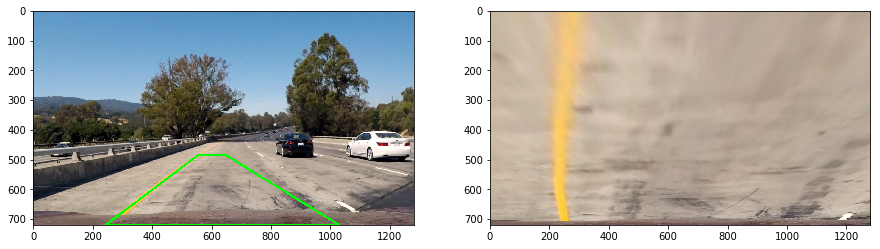

In [6]:
import time
test_path = './test_images/'
imgs = [cv2.imread(os.path.join(test_path, x)) for x in os.listdir(test_path) ]
pt = PerspectiveTransformer()

hl = HoughLines(
                cmaps=[
                      (cv2.COLOR_BGR2HLS, [0,1,2]),
                       (cv2.COLOR_BGR2RGB, [0,1,2])
                ]
                )
x_ratio_bottom = 0.14
x_ratio_top = 0.4
y_ratio = 0.6
img = imgs[0].copy()
y_size, x_size, _ = img.shape
vertices =  np.array([[[x_ratio_bottom*x_size, y_size], [x_ratio_top*x_size,y_ratio*y_size],\
                                               [(1-x_ratio_top)*x_size,y_ratio*y_size ],\
                       [(1-x_ratio_bottom)*x_size,y_size ]]], dtype=np.int32)
fig = plt.figure(figsize=(15,10))
imgs_ = imgs.copy()
for i, img in enumerate([imgs_[7]]):
    t1 = time.time()
    avg_coefs, line_coefs = hl.get_lines_by_coefs(img, vertices,hough_threshold=25,
                  min_line_len = 20, max_line_gap = 10, angle = 20,
                  canny_kernel=3, canny_low=75, canny_high=200)
    trans_vert = hl.calc_vertices_for_transform(y_size, x_size, avg_coefs, 30)
    warped_img = pt.warp_img(img, trans_vert)
    print('time {}'.format(time.time()-t1))
    im__ = cv2.polylines(img, np.int32([trans_vert]), True, (0,255,0), thickness=6)
    fig.add_subplot(1,2,i+1)
    plt.imshow(cv2.cvtColor(im__, cv2.COLOR_BGR2RGB))
    fig.add_subplot(1,2,i+2)
    plt.imshow(cv2.cvtColor(warped_img, cv2.COLOR_BGR2RGB))
    break

In [8]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

#### harder challenge video

In [83]:
hl = HoughLines(cmaps=[(cv2.COLOR_RGB2LAB, [0]),
                       (cv2.COLOR_RGB2YCrCb, [0]),
                       (None, [0,1,2])], prepocess=True, keep=25, serial_mode=True)
x_ratio_bottom = 0.14
x_ratio_top = 0.4
y_ratio = 0.6
img = imgs[0].copy()
y_size, x_size, _ = img.shape
vertices =  np.array([[[x_ratio_bottom*x_size, y_size], [x_ratio_top*x_size,y_ratio*y_size],\
                                               [(1-x_ratio_top)*x_size,y_ratio*y_size ],\
                       [(1-x_ratio_bottom)*x_size,y_size ]]], dtype=np.int32)
# setting params for roi drawing
hl.set_params_for_get_lines(vertices,hough_threshold=25,
                  min_line_len = 30, max_line_gap = 10, angle = 20,
                  canny_kernel=5, canny_low=100, canny_high=255)
# initialize frame gen
frame_gen = hl.draw_roi_for_transform
# make video
output = './hard_test_with_roi_lab_corr.mp4'
clip1 = VideoFileClip("./harder_challenge_video.mp4")
white_clip = clip1.fl_image(frame_gen) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./hard_test_with_roi_lab_corr.mp4
[MoviePy] Writing video ./hard_test_with_roi_lab_corr.mp4


100%|█████████▉| 1199/1200 [04:17<00:00,  4.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./hard_test_with_roi_lab_corr.mp4 

CPU times: user 11min 18s, sys: 1min 19s, total: 12min 37s
Wall time: 4min 18s


#### challenge video

In [84]:
hl = HoughLines(cmaps=[(cv2.COLOR_RGB2LAB, [0]),
                       (cv2.COLOR_RGB2YCrCb, [0]),
                       (None, [0,1,2])], prepocess=True, keep=25, serial_mode=True)
x_ratio_bottom = 0.14
x_ratio_top = 0.4
y_ratio = 0.6
img = imgs[0].copy()
y_size, x_size, _ = img.shape
vertices =  np.array([[[x_ratio_bottom*x_size, y_size], [x_ratio_top*x_size,y_ratio*y_size],\
                                               [(1-x_ratio_top)*x_size,y_ratio*y_size ],\
                       [(1-x_ratio_bottom)*x_size,y_size ]]], dtype=np.int32)
# setting params for roi drawing
hl.set_params_for_get_lines(vertices,hough_threshold=25,
                  min_line_len = 30, max_line_gap = 10, angle = 20,
                  canny_kernel=5, canny_low=100, canny_high=255)
# initialize frame gen
frame_gen = hl.draw_roi_for_transform
# make video
output = './challenge_test_with_roi_lab_corr.mp4'
clip1 = VideoFileClip("./challenge_video.mp4")
white_clip = clip1.fl_image(frame_gen) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./challenge_test_with_roi_lab_corr.mp4
[MoviePy] Writing video ./challenge_test_with_roi_lab_corr.mp4


100%|██████████| 485/485 [01:29<00:00,  5.41it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./challenge_test_with_roi_lab_corr.mp4 

CPU times: user 4min 35s, sys: 34.2 s, total: 5min 9s
Wall time: 1min 30s


#### project video

In [85]:
hl = HoughLines(cmaps=[(cv2.COLOR_RGB2LAB, [0]),
                       (cv2.COLOR_RGB2YCrCb, [0]),
                       (None, [0,1,2])], prepocess=True, keep=25, serial_mode=True)
x_ratio_bottom = 0.14
x_ratio_top = 0.4
y_ratio = 0.6
img = imgs[0].copy()
y_size, x_size, _ = img.shape
vertices =  np.array([[[x_ratio_bottom*x_size, y_size], [x_ratio_top*x_size,y_ratio*y_size],\
                                               [(1-x_ratio_top)*x_size,y_ratio*y_size ],\
                       [(1-x_ratio_bottom)*x_size,y_size ]]], dtype=np.int32)
# setting params for roi drawing
hl.set_params_for_get_lines(vertices,hough_threshold=25,
                  min_line_len = 30, max_line_gap = 10, angle = 20,
                  canny_kernel=5, canny_low=100, canny_high=255)
# initialize frame gen
frame_gen = hl.draw_roi_for_transform
# make video
output = './project_test_with_roi_lab_corr.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(frame_gen) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./project_test_with_roi_lab_corr.mp4
[MoviePy] Writing video ./project_test_with_roi_lab_corr.mp4


100%|█████████▉| 1260/1261 [04:00<00:00,  5.24it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_test_with_roi_lab_corr.mp4 

CPU times: user 12min 3s, sys: 1min 28s, total: 13min 31s
Wall time: 4min 1s


#### Cut hard part

In [20]:
import time
clip = VideoFileClip("./harder_challenge_video.mp4").subclip(26,30)
if not os.path.exists('./hard_subclip_imgs'):
    os.mkdir('./hard_subclip_imgs')
if not os.path.exists('./hard_subclip_imgs/in'):
    os.mkdir('./hard_subclip_imgs/in')
saving_path = './hard_subclip_imgs/in'
for frame in clip.iter_frames():
    t = time.time()
    t *= 10000
    t = int(t)
    fname = str(t) + '.jpg'
    mpimg.imsave(os.path.join(saving_path, fname), frame)

In [21]:
hfiles = [os.path.join(saving_path, x) for x in os.listdir(saving_path) if x.endswith('.jpg')]
hfiles.sort()

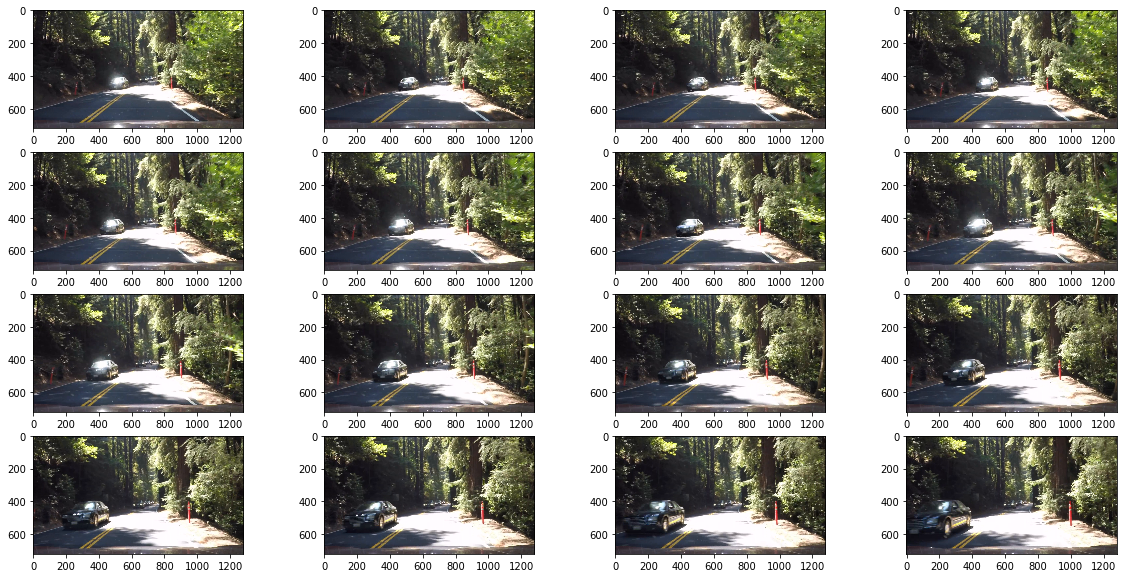

In [22]:
fig = plt.figure(figsize=(20,10))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(mpimg.imread(hfiles[i]))

In [68]:
hl = HoughLines(cmaps=[#(cv2.COLOR_RGB2HLS, [0]),
                       (None, [0,1,2])], prepocess=True, keep=10, serial_mode=True)
x_ratio_bottom = 0.14
x_ratio_top = 0.4
y_ratio = 0.6
img = imgs[0].copy()
y_size, x_size, _ = img.shape
vertices =  np.array([[[x_ratio_bottom*x_size, y_size], [x_ratio_top*x_size,y_ratio*y_size],\
                                               [(1-x_ratio_top)*x_size,y_ratio*y_size ],\
                       [(1-x_ratio_bottom)*x_size,y_size ]]], dtype=np.int32)
# setting params for roi drawing
hl.set_params_for_get_lines(vertices,hough_threshold=25,
                  min_line_len = 30, max_line_gap = 10, angle = 20,
                  canny_kernel=5, canny_low=100, canny_high=255)
# initialize frame gen
saving_path = './hard_subclip_imgs/out'
for file in hfiles:
    img = mpimg.imread(file)
    img_with_roi = hl.draw_roi_for_transform(img)
    fname = os.path.split(file)[-1]
    fname = 'roi_' + fname
    cv2.imwrite(os.path.join(saving_path, fname),cv2.cvtColor(img_with_roi, cv2.COLOR_RGB2BGR))

In [69]:
roi_hfiles = [os.path.join(saving_path, x) for x in os.listdir(saving_path) if x.endswith('.jpg')]
roi_hfiles.sort()

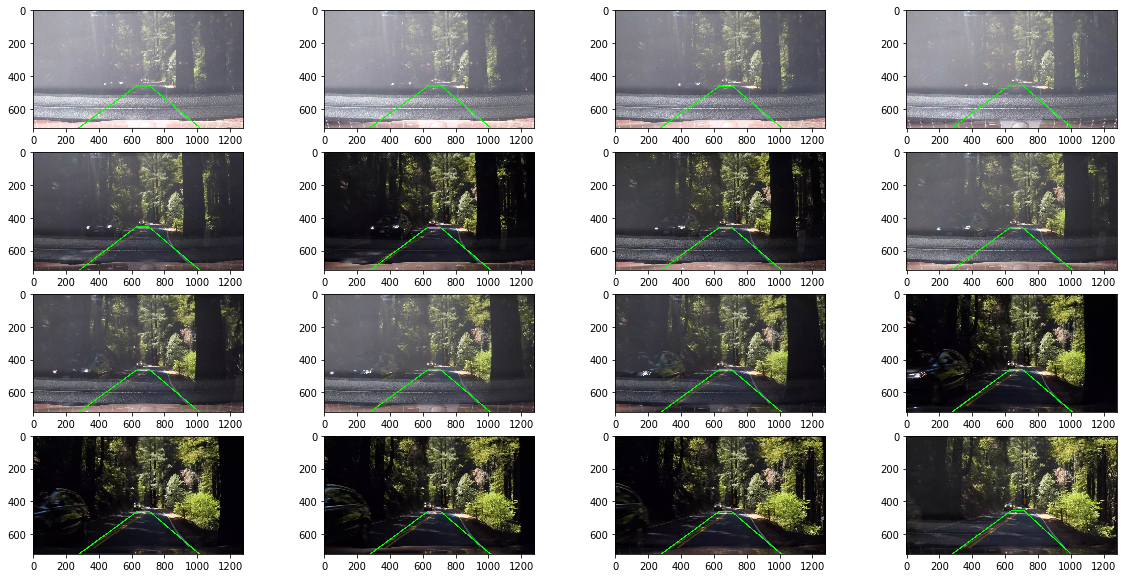

In [70]:
fig = plt.figure(figsize=(20,10))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(mpimg.imread(roi_hfiles[i+50]))

In [40]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [20]:
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """

    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    try:
        diff = np.sqrt(diff)
    except AttributeError:
        print(points)
        print(diff)
        raise
    med_abs_deviation = np.median(diff)
    modified_z_score = 0.6745 * diff / med_abs_deviation
    return modified_z_score > thresh